# 03 - SelfClean

## Import necessary libraries and download dataset

In [1]:
!pip install selfclean -Uq
!pip freeze | grep selfclean

selfclean==0.0.9


In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
import copy
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
from torchvision import datasets, transforms
from selfclean import SelfClean
from selfclean.cleaner.selfclean import PretrainingType

if IN_COLAB:
    !git clone https://github.com/Digital-Dermatology/data-cleaning-hands-on.git
    sys.path.append("data-cleaning-hands-on")
else:
    sys.path.append("../")

from utils import get_oxford_pets3t, get_imagenette

We start by downloading our dataset to analyze.

Either you want to analyze analyze Oxford PetIIIT:

In [4]:
dataset_name = "OxfordIIITPet"
data_path = Path("../data/") / dataset_name
dataset, df = get_oxford_pets3t(
    root_path=data_path, return_dataframe=True, transform=transforms.Resize((256, 256))
)

dataset

Oxford PetIIIT already downloaded to `../data/OxfordIIITPet`.


Dataset ImageFolder
    Number of datapoints: 7390
    Root location: ../data/OxfordIIITPet
    StandardTransform
Transform: Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)

or ImageNette:

In [5]:
# dataset_name = "ImageNette"
# data_path = Path("../data/")
# dataset, df = get_imagenette(
#    root_path=data_path, return_dataframe=True, transform=transforms.Resize((256, 256))
# )
# dataset

or your own collection:

In [6]:
# 2nd option -> analyze your own data
# dataset_name = "NameOfYourDataset"
# dataset = ImageFolder(root='path/to/dataset')

## Run SelfClean

As a first step, SelfClean will train a model using self-supervised learning on the provided dataset.
Afterwards it will use the learned representations to detect data quality issues using simple scoring functions.

Self-supervised pre-training can take some time that's why we set the number of pre-training epochs here to `10`.
However to acheive optimal performance we suggest letting it run for longer.

In [7]:
if IN_COLAB:
    pre_computed_path = Path("data-cleaning-hands-on/pre_computed_assets/SelfClean")
else:
    pre_computed_path = Path("../pre_computed_assets/SelfClean")

2024-03-22 09:46:31.742 | INFO     | Found checkpoint at /tmp/tmp8eo3bdy4
2024-03-22 09:46:31.971 | INFO     | Found checkpoint at /tmp/tmp8eo3bdy4
2024-03-22 09:46:32.126 | INFO     | Found checkpoint at /tmp/tmp8eo3bdy4
2024-03-22 09:46:35.066 | INFO     | Found checkpoint at /tmp/tmpkks8w0d_
2024-03-22 09:46:35.216 | INFO     | Found checkpoint at /tmp/tmpkks8w0d_
2024-03-22 09:46:35.354 | INFO     | Found checkpoint at /tmp/tmpkks8w0d_
2024-03-22 09:46:35.606 | INFO     | Found checkpoint at ../pre_computed_assets/SelfClean/DINO-OxfordIIITPet/checkpoints/model_best.pth


Creating dataset representation:   0%|          | 0/462 [00:00<?, ?it/s]

Creating distance matrix:   0%|          | 0/74 [00:00<?, ?it/s]

Processing possible near duplicates:   0%|          | 0/2731 [00:00<?, ?it/s]

Processing possible irrelevant samples: 0it [00:00, ?it/s]

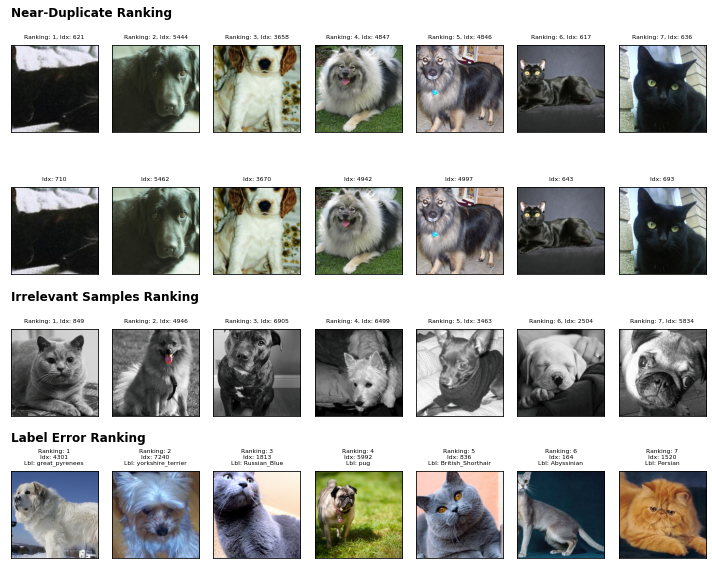

In [8]:
selfclean = SelfClean(
    plot_top_N=7,
)
issues = selfclean.run_on_dataset(
    dataset=copy.copy(dataset),
    pretraining_type=PretrainingType.DINO,
    num_workers=os.cpu_count(),
    epochs=10,
    batch_size=16,
    dataset_name=dataset_name,
    work_dir=pre_computed_path,
)

Let's look at each issue type in more detail.

### Near duplicates

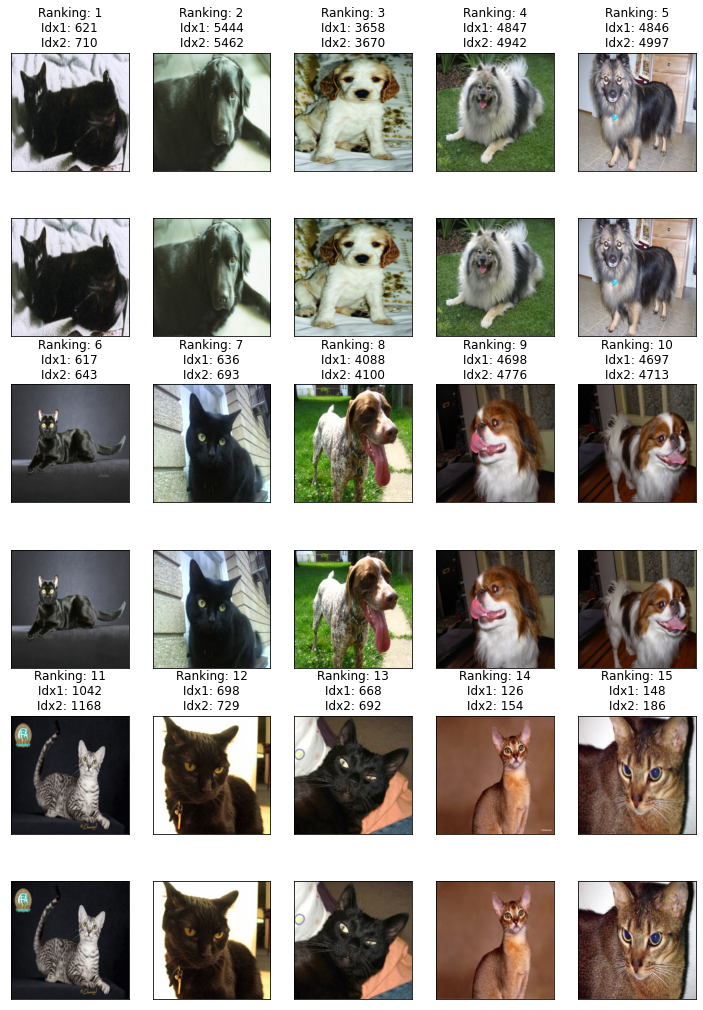

In [9]:
r_index = 0
fig, axes = plt.subplots(6, 5, figsize=(10, 14))
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        if h_idx % 2 == 1:
            continue

        idx1, idx2 = issues["near_duplicates"]["indices"][r_index]
        idx1, idx2 = int(idx1), int(idx2)

        ax.imshow(dataset[idx1][0])
        axes[h_idx + 1, v_idx].imshow(dataset[idx2][0])
        ax.set_title(f"Ranking: {r_index+1}" f"\nIdx1: {idx1}" f"\nIdx2: {idx2}")
        ax.set_xticks([])
        ax.set_yticks([])
        axes[h_idx + 1, v_idx].set_xticks([])
        axes[h_idx + 1, v_idx].set_yticks([])
        r_index += 1

fig.tight_layout()
plt.show()

In [10]:
df_near_duplicates = issues.get_issues("near_duplicates", return_as_df=True)
df_near_duplicates.head()

2024-03-22 09:48:18.845 | WARNING  | Returning as dataframe requires extensive memory.


,indices_1,indices_2,scores,label_indices_1,label_indices_2
0,621,710,0.000000e+00,Bombay,Bombay
1,5444,5462,0.000000e+00,newfoundland,newfoundland
2,3658,3670,1.192093e-07,english_cocker_spaniel,english_cocker_spaniel
3,4847,4942,1.251698e-06,keeshond,keeshond
4,4846,4997,1.311302e-06,keeshond,keeshond


### Irrelevant Samples

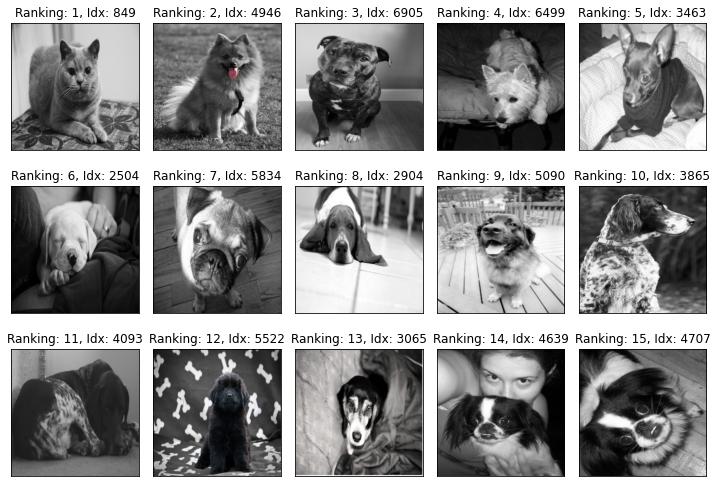

In [11]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = issues["irrelevants"]["indices"][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(f"Ranking: {r_index+1}, Idx: {idx}")
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

In [12]:
df_irrelevants = issues.get_issues("irrelevants", return_as_df=True)
df_irrelevants.head()

2024-03-22 09:48:27.129 | WARNING  | Returning as dataframe requires extensive memory.


,indices,scores,label
0,849,0.752790,British_Shorthair
1,4946,0.758318,keeshond
2,6905,0.758945,staffordshire_bull_terrier
3,6499,0.760953,scottish_terrier
4,3463,0.762919,chihuahua


### Label Errors

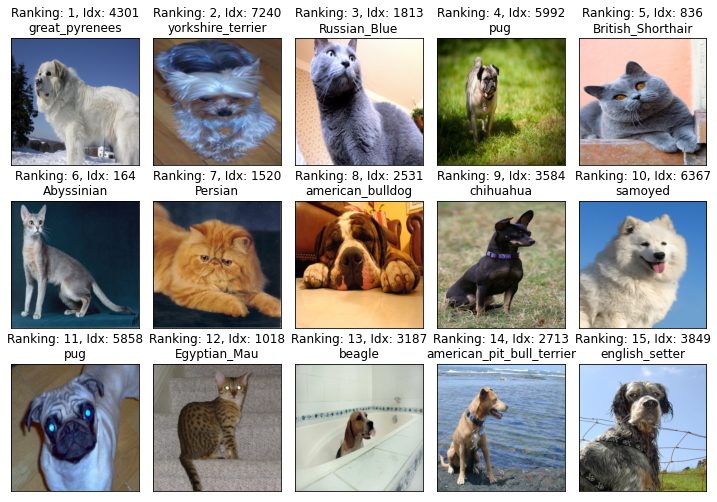

In [13]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = issues["label_errors"]["indices"][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(
            f"Ranking: {r_index+1}, Idx: {idx}" f"\n{dataset.classes[dataset[idx][1]]}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

In [14]:
df_label_errors = issues.get_issues("label_errors", return_as_df=True)
df_label_errors.head()

2024-03-22 09:48:27.743 | WARNING  | Returning as dataframe requires extensive memory.


,indices,scores,label
0,4301,0.079868,great_pyrenees
1,7240,0.089737,yorkshire_terrier
2,1813,0.090912,Russian_Blue
3,5992,0.094904,pug
4,836,0.095020,British_Shorthair
